# 低压电力预测


## 导入相关库


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sktime.utils.plotting import plot_series
import seaborn as sns
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.base import ForecastingHorizon
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.compose import OptionalPassthrough
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm import tqdm
from pytorch_forecasting import TimeSeriesDataSet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

warnings.filterwarnings("ignore")
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS"]
%matplotlib inline
%config InlineBackend.figure_format='retina'

## 读取数据集


In [2]:
# 选取一天内数据观察
df = pd.read_csv(
    "../data/dnaq_15Min_interval.csv",
    parse_dates=["collection_time"],
    index_col="collection_time",
)
df = df.loc["2022-01-01":"2022-01-8"]

In [3]:
y = df[["Ia", "Ib", "Ic", "Ua", "Ub", "Uc"]]
y.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 00:15:00',
               '2022-01-01 00:30:00', '2022-01-01 00:45:00',
               '2022-01-01 01:00:00', '2022-01-01 01:15:00',
               '2022-01-01 01:30:00', '2022-01-01 01:45:00',
               '2022-01-01 02:00:00', '2022-01-01 02:15:00',
               ...
               '2022-01-08 21:30:00', '2022-01-08 21:45:00',
               '2022-01-08 22:00:00', '2022-01-08 22:15:00',
               '2022-01-08 22:30:00', '2022-01-08 22:45:00',
               '2022-01-08 23:00:00', '2022-01-08 23:15:00',
               '2022-01-08 23:30:00', '2022-01-08 23:45:00'],
              dtype='datetime64[ns]', name='collection_time', length=768, freq=None)

In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 2022-01-01 00:00:00 to 2022-01-08 23:45:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ia      768 non-null    float64
 1   Ib      768 non-null    float64
 2   Ic      768 non-null    float64
 3   Ua      768 non-null    float64
 4   Ub      768 non-null    float64
 5   Uc      768 non-null    float64
dtypes: float64(6)
memory usage: 42.0 KB


## 数据分析


### 查看 Ia 参数时序图


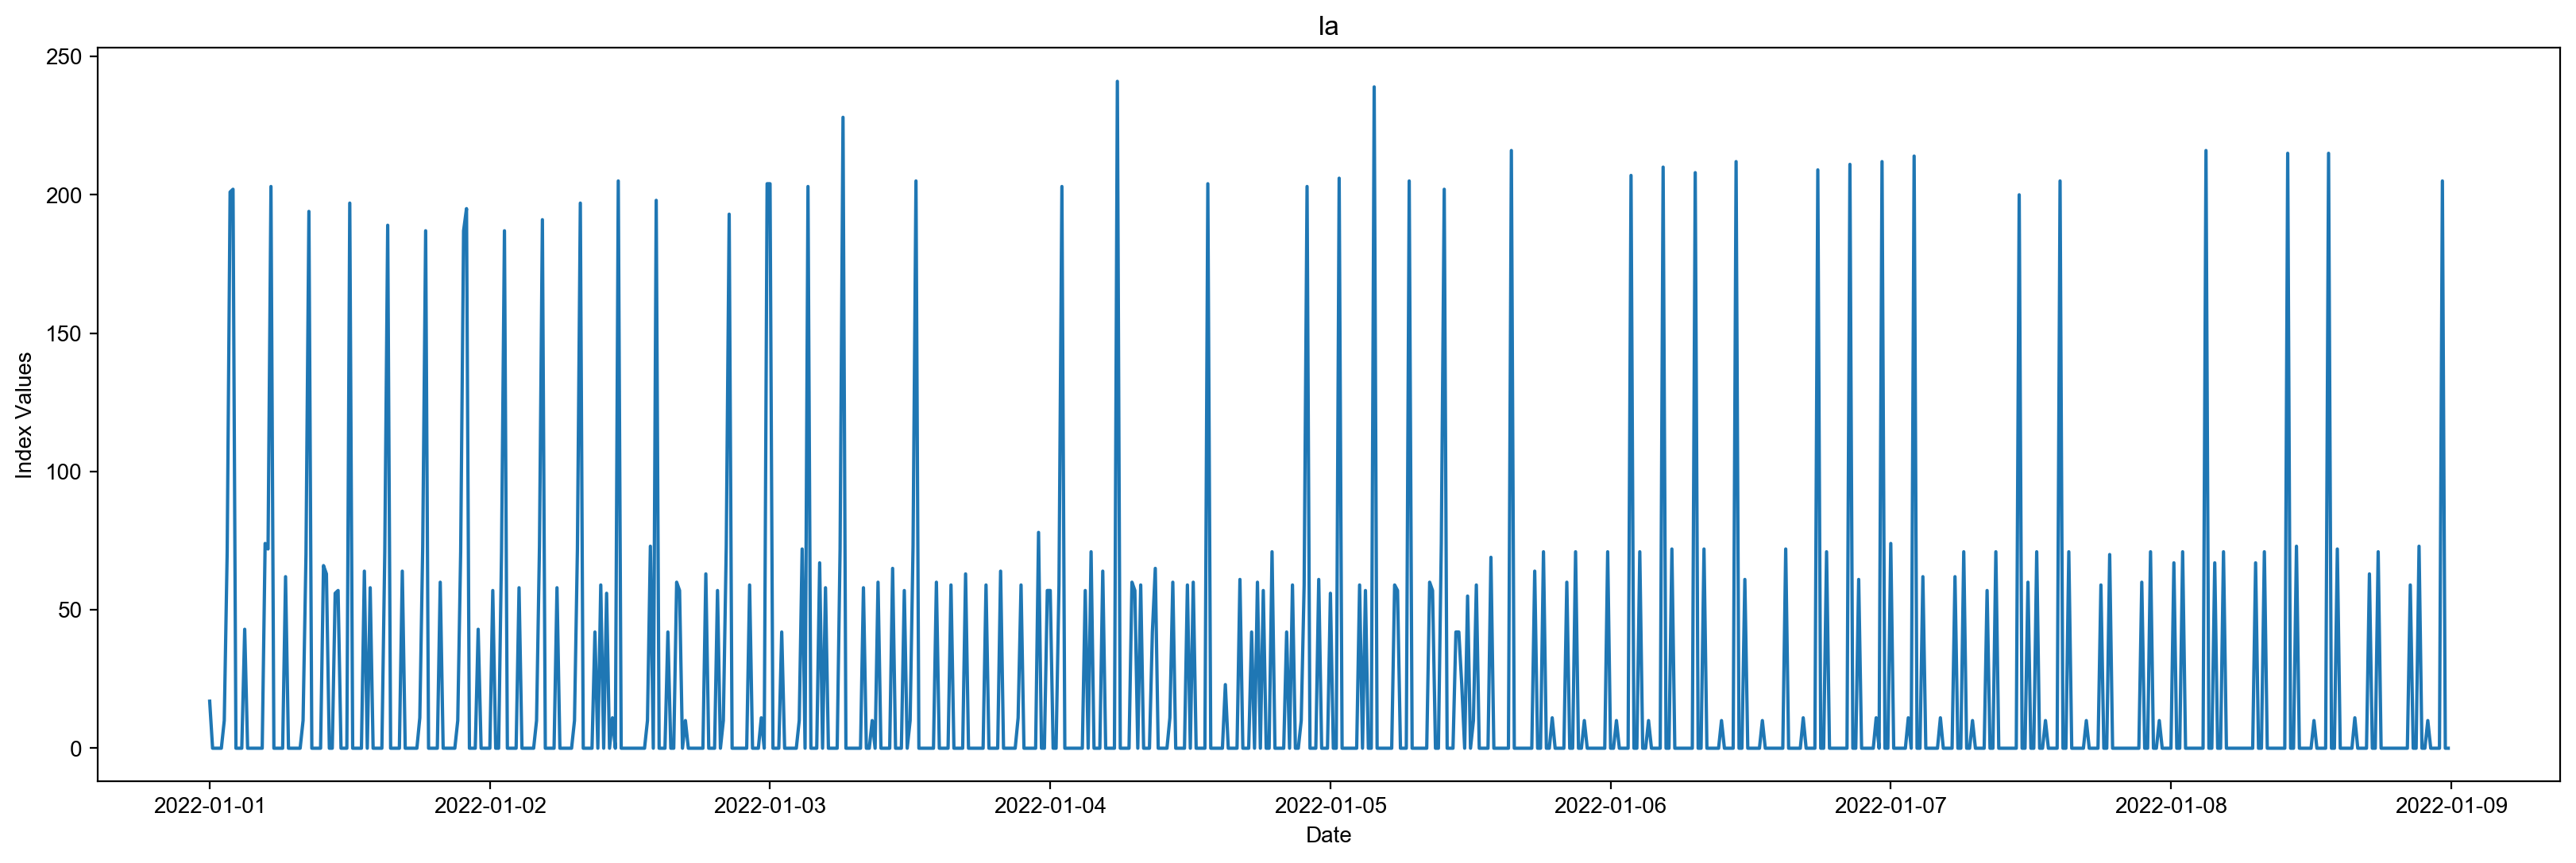

In [124]:
plt.figure(figsize=(20, 6))
plt.plot(y.index, y["Ia"])
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.title("Ia")
plt.show()

### 查看 Ib 时序图


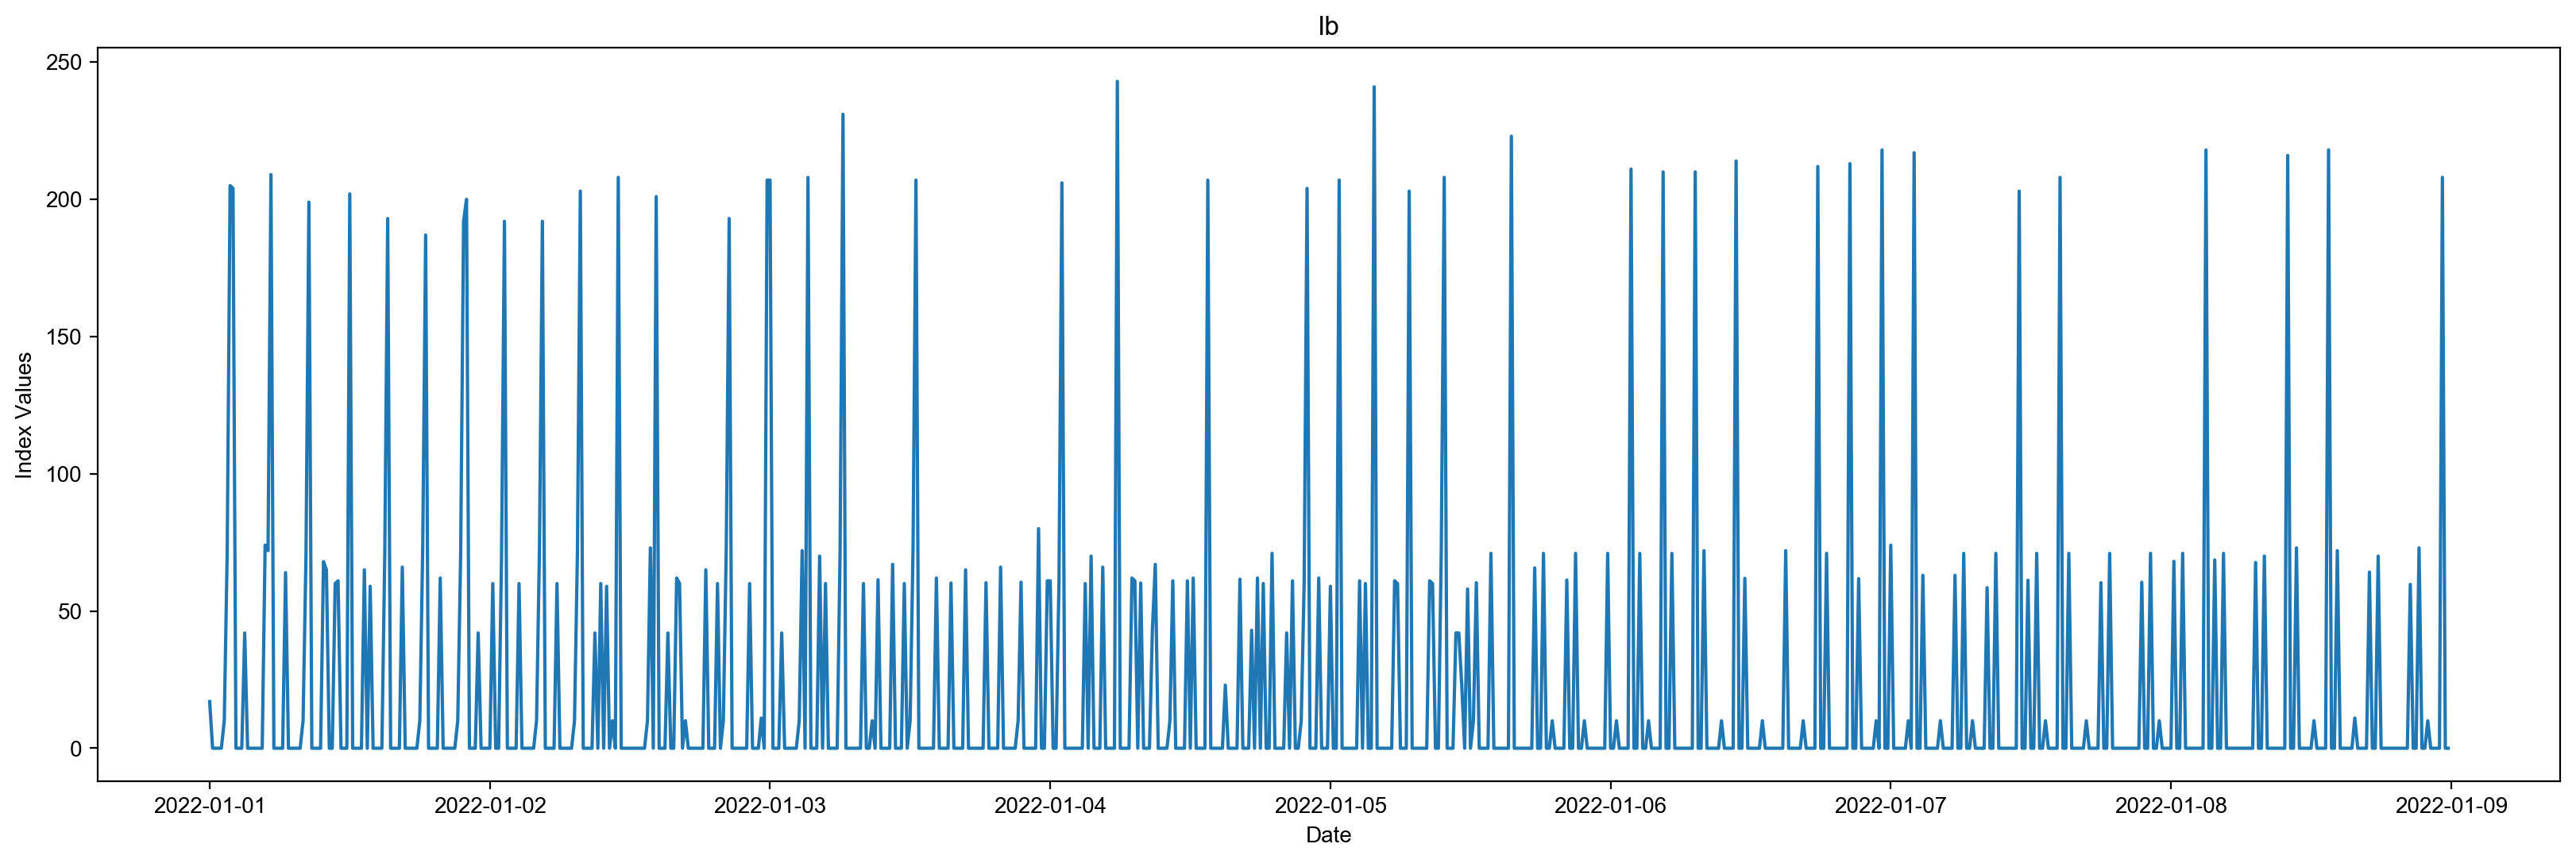

In [125]:
# 查看 Ib 参数时序图
plt.figure(figsize=(20, 6))
plt.plot(y.index, y["Ib"])
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.title("Ib")
plt.show()

### 查看 Ic 时序图


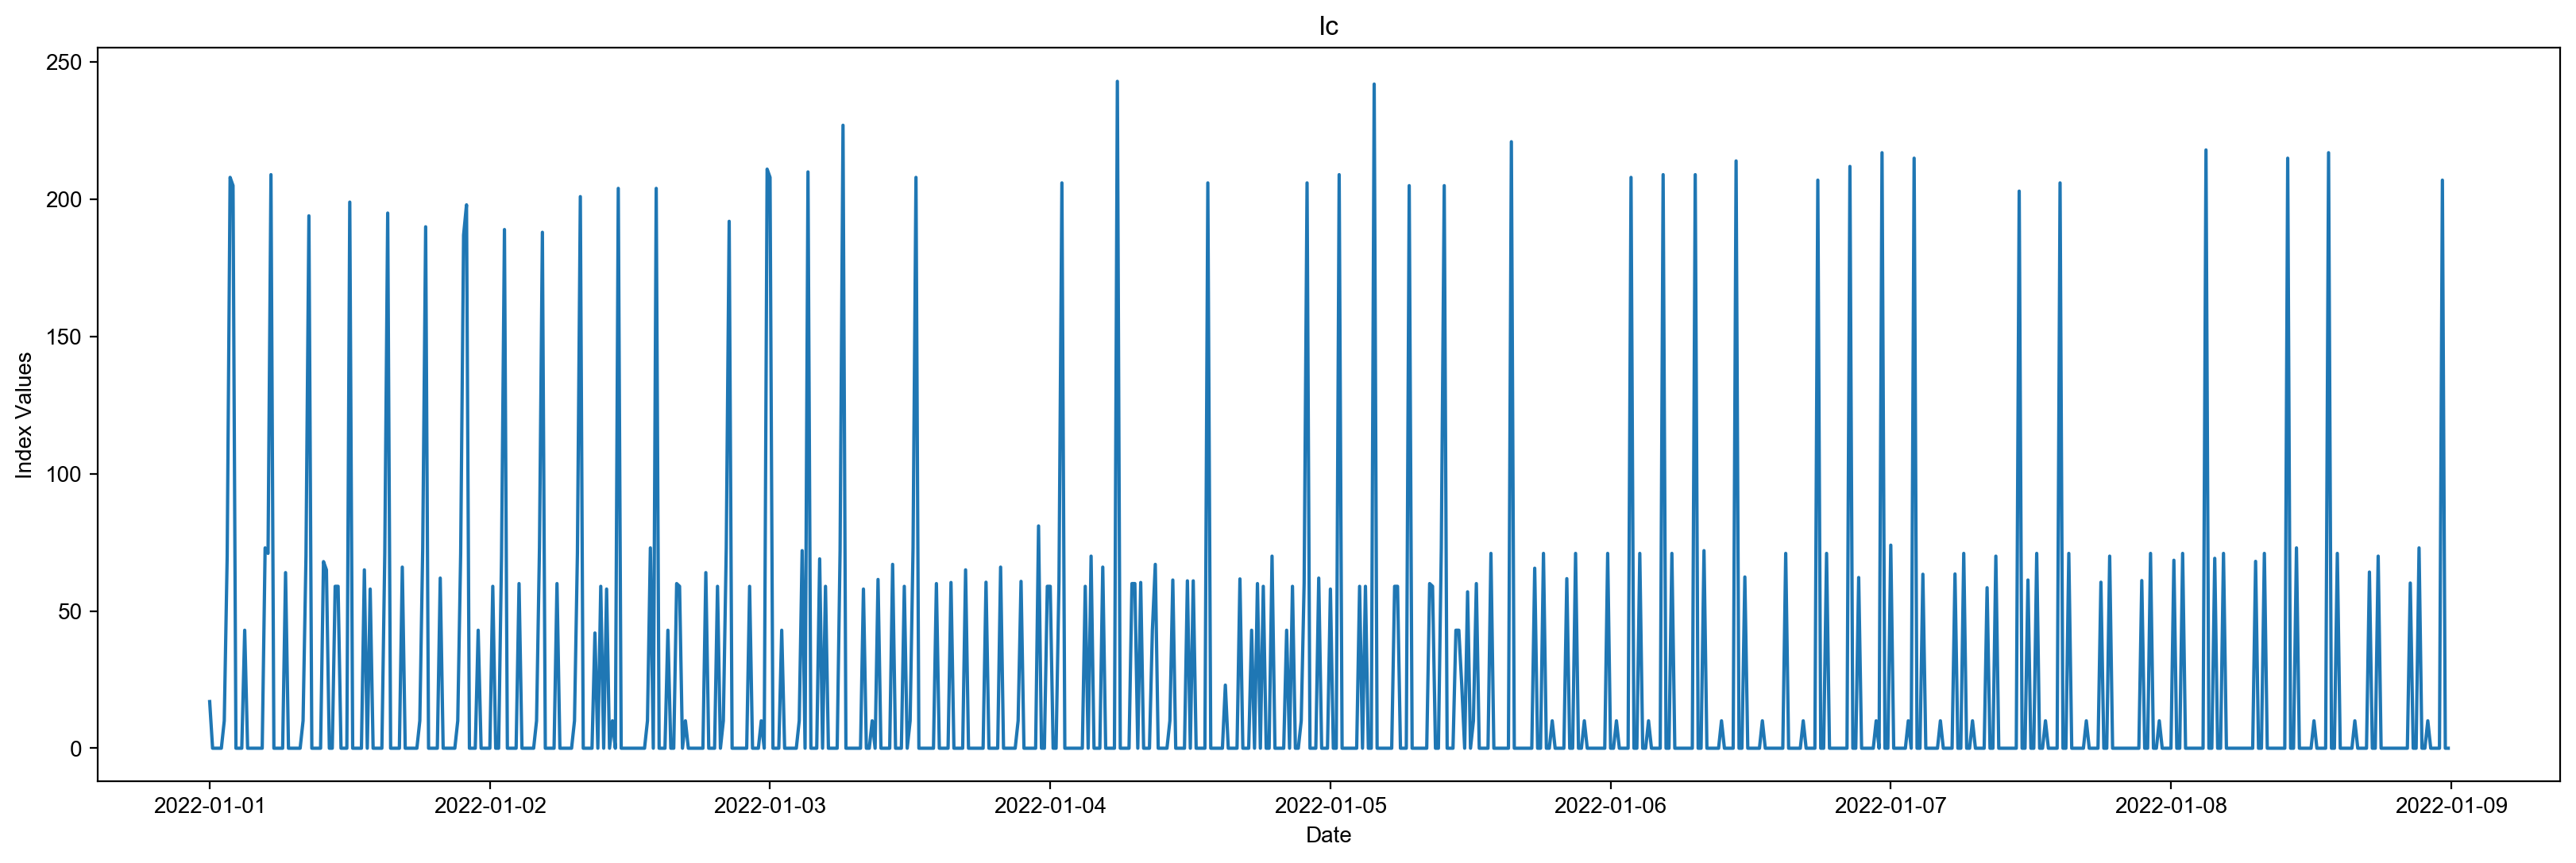

In [126]:
# 查看 Ic 参数时序图
plt.figure(figsize=(20, 6))
plt.plot(y.index, y["Ic"])
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.title("Ic")
plt.show()

发现三个数据具有类似的周期性，且具有一定的相关性


### 查看三相电压时序图


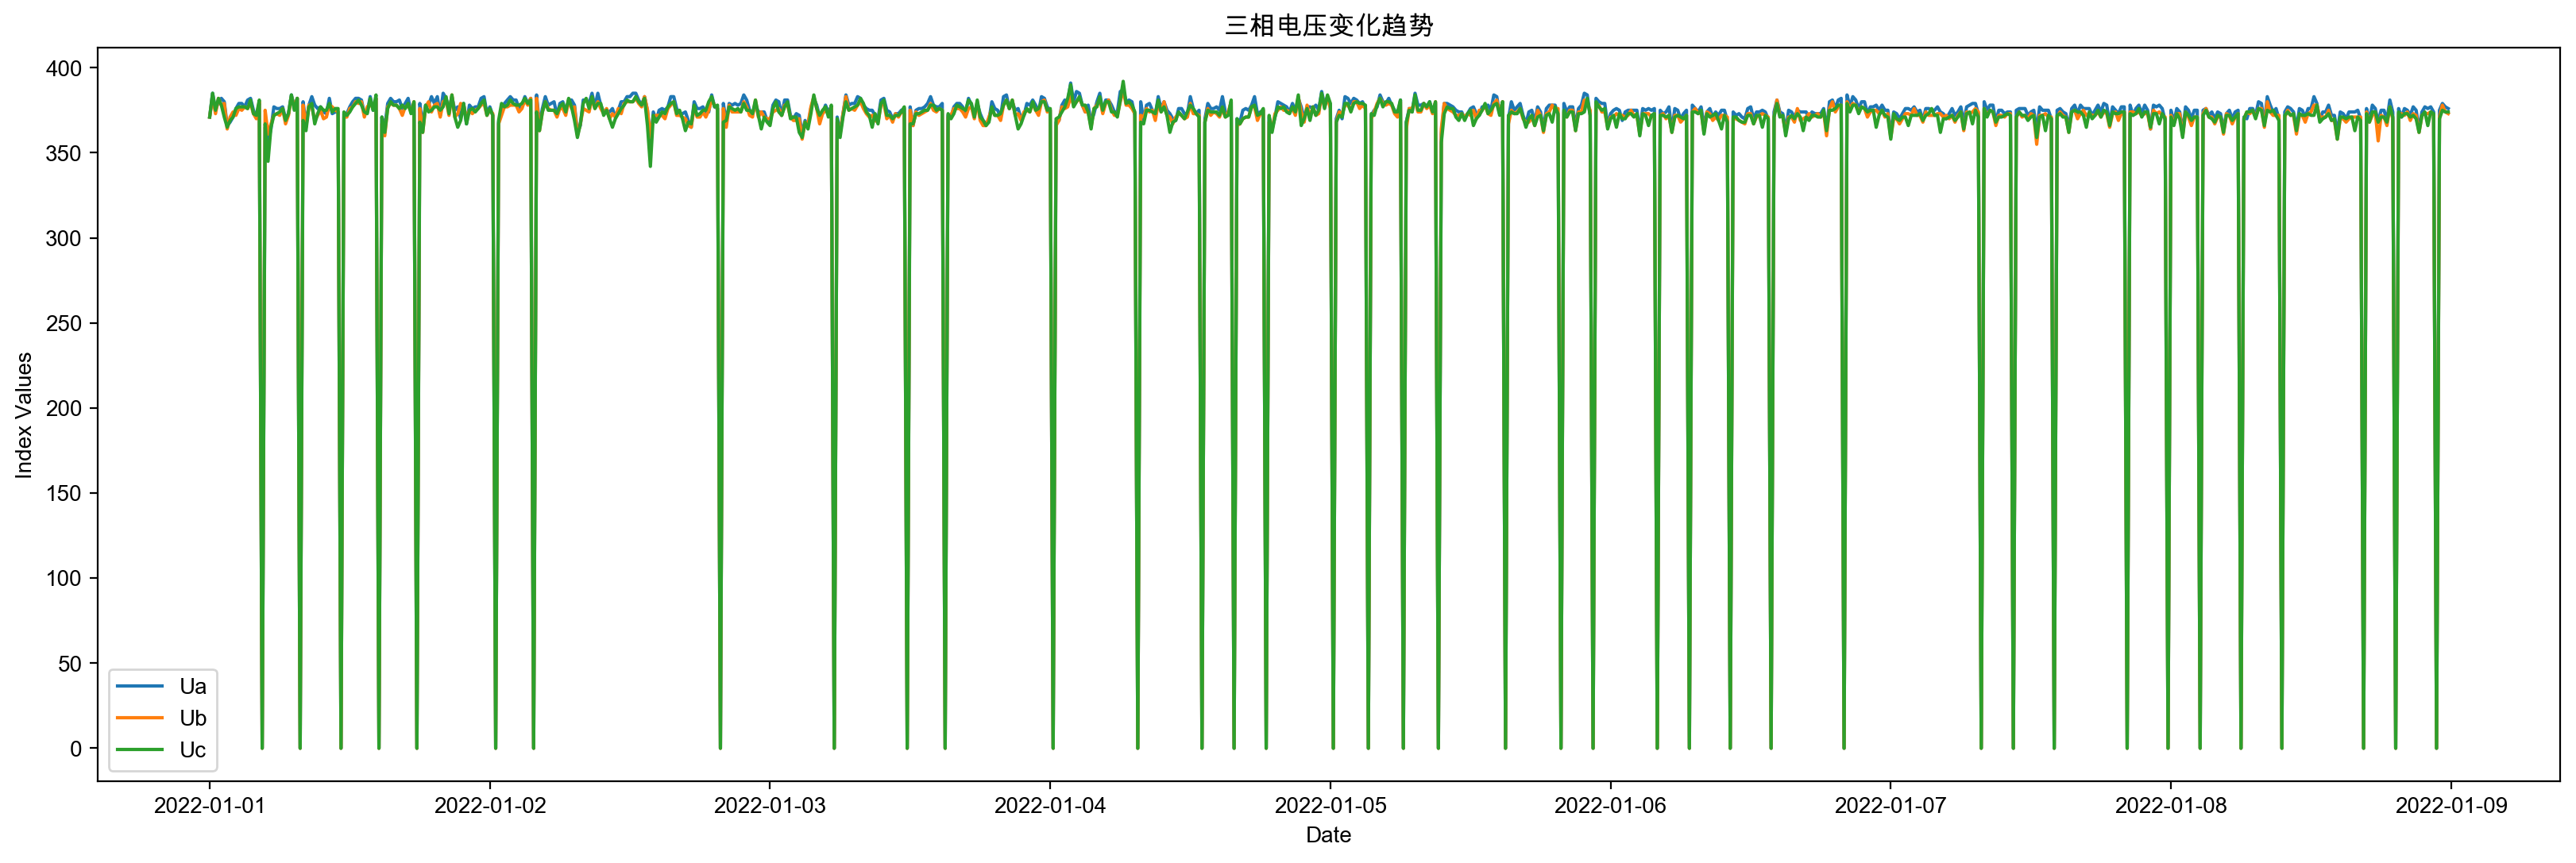

In [127]:
# 查看 Ua 参数时序图
plt.figure(figsize=(20, 6))
plt.plot(y.index, y[["Ua", "Ub", "Uc"]], label=["Ua", "Ub", "Uc"])
plt.xlabel("Date")
plt.ylabel("Index Values")
plt.title("三相电压变化趋势")
plt.legend()
plt.show()

### 查看特征分布直方图


array([[<Axes: title={'center': 'COS'}>, <Axes: title={'center': 'P'}>,
        <Axes: title={'center': 'Ia'}>],
       [<Axes: title={'center': 'Ib'}>, <Axes: title={'center': 'Ic'}>,
        <Axes: title={'center': 'Ua'}>],
       [<Axes: title={'center': 'Ub'}>, <Axes: title={'center': 'Uc'}>,
        <Axes: title={'center': 'elec_degree'}>]], dtype=object)

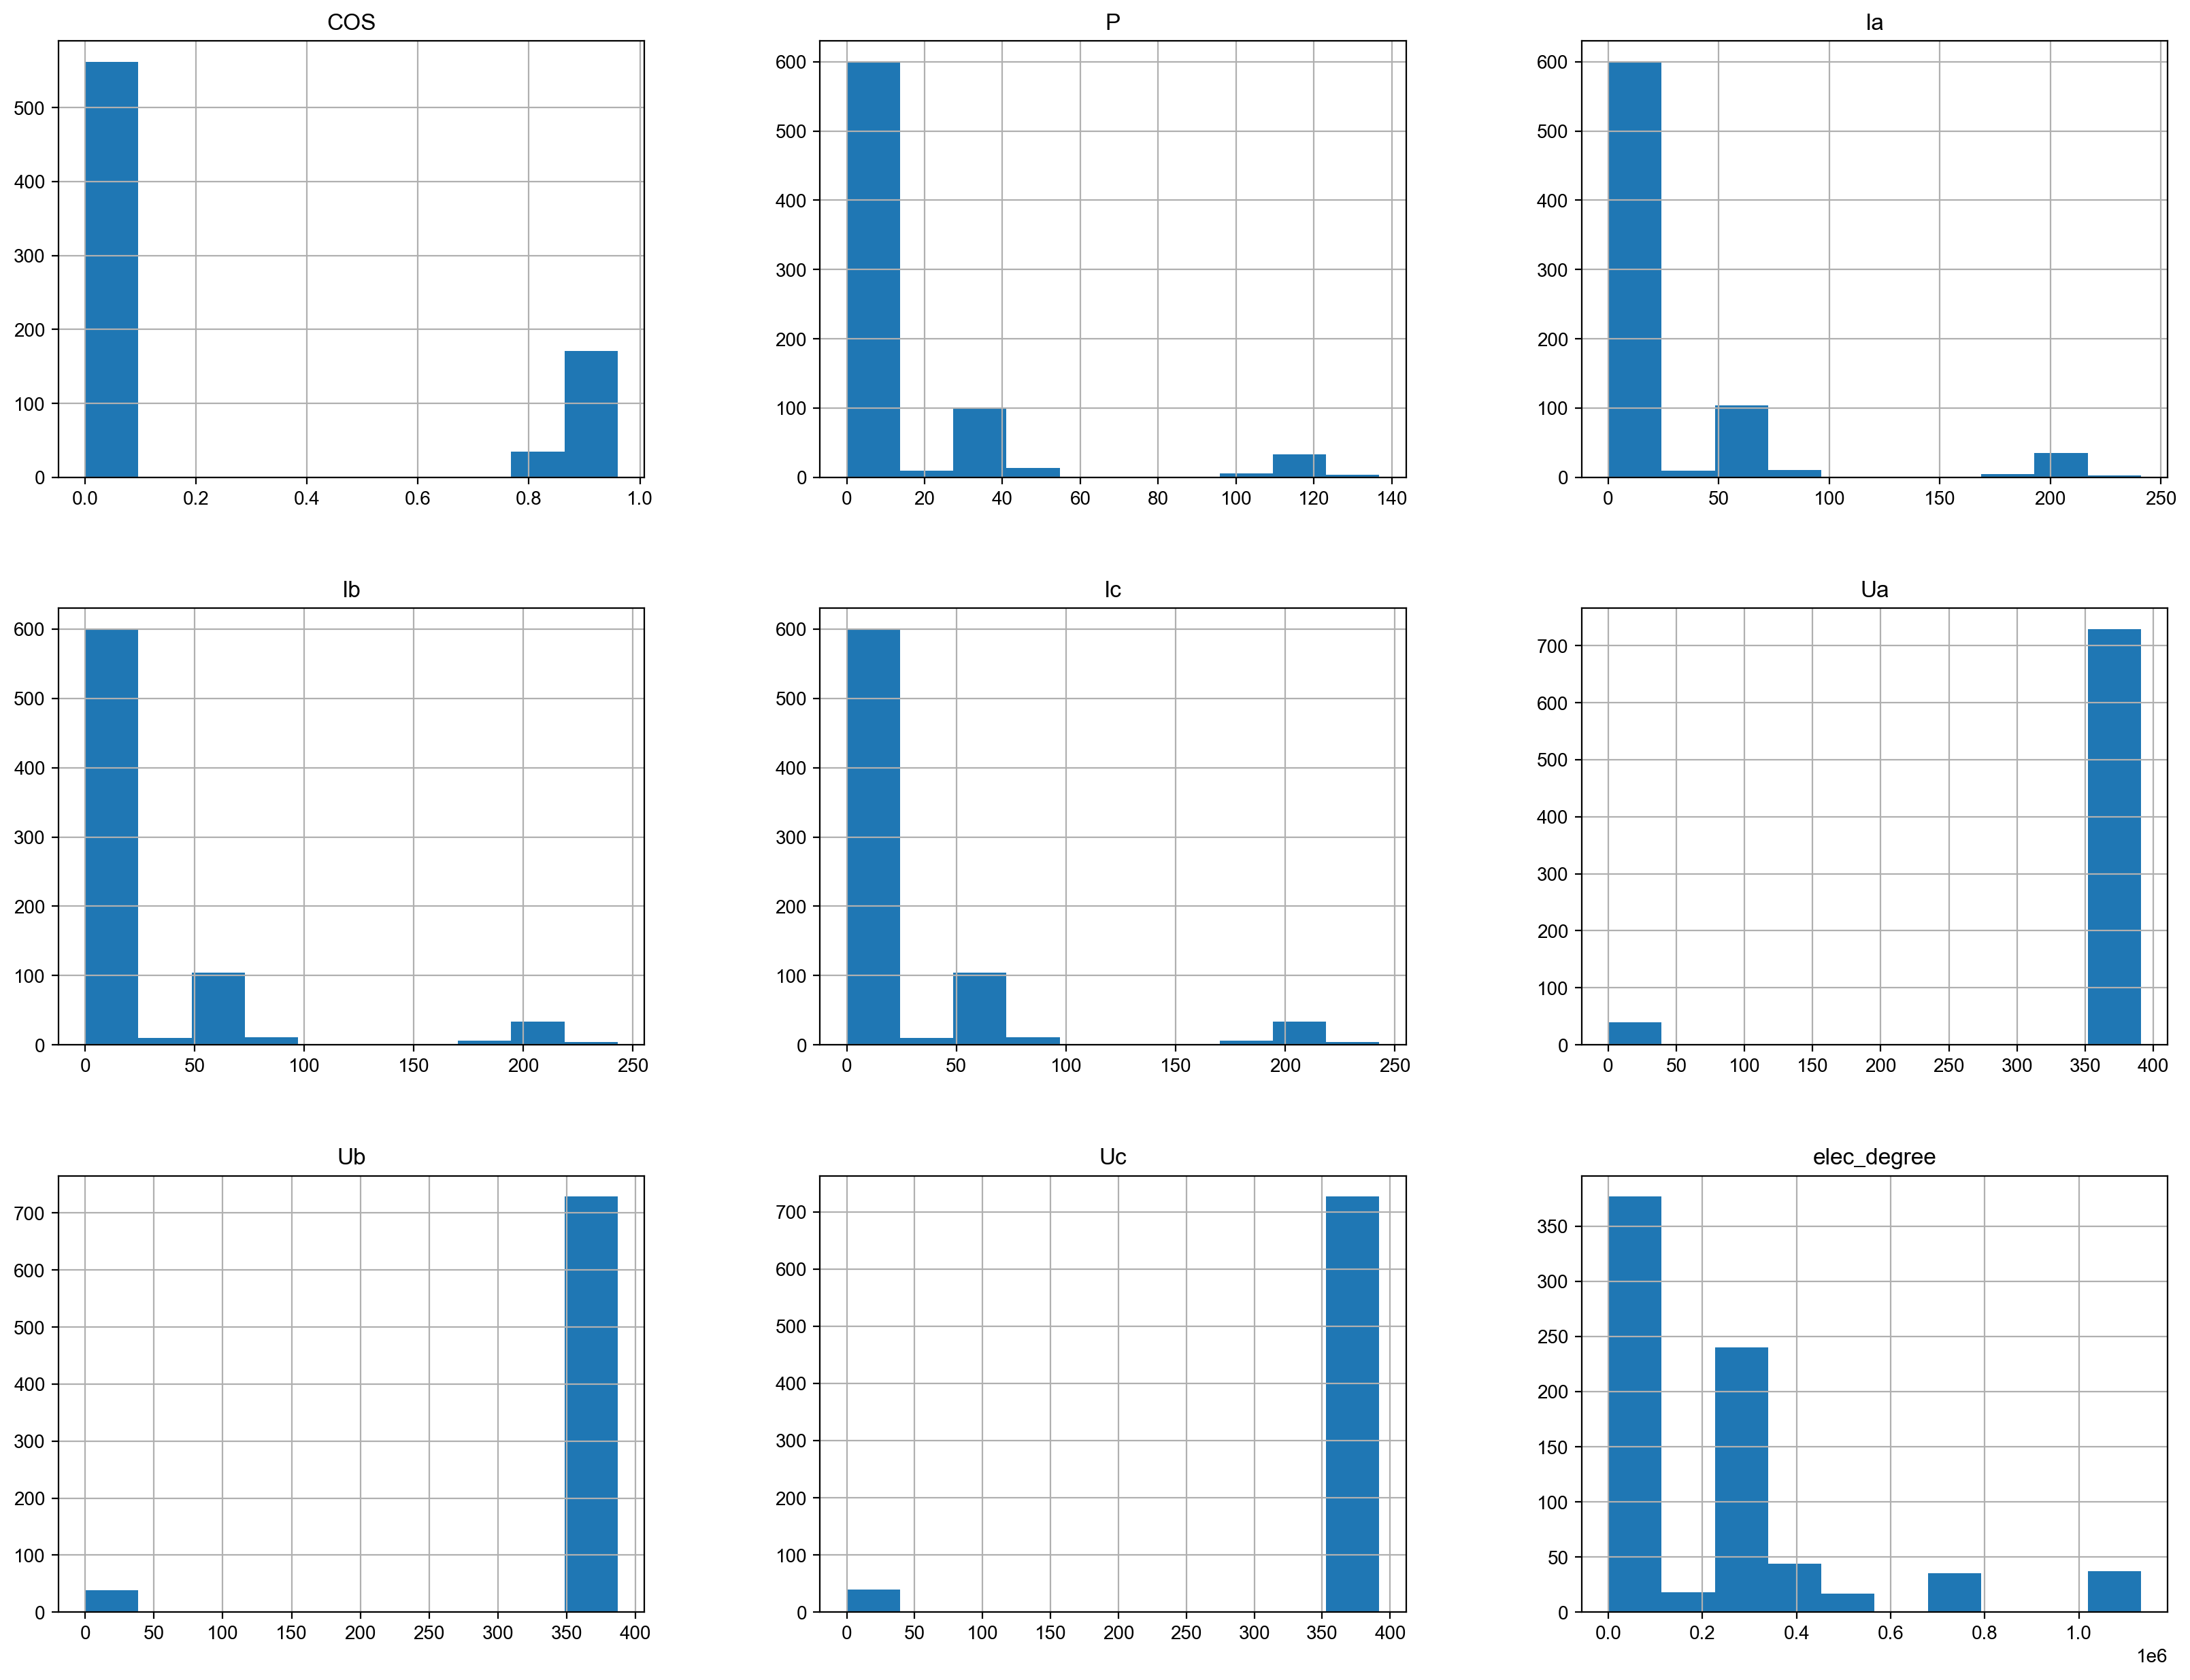

In [128]:
df.hist(figsize=(20, 15))

### 查看特征相关热力图


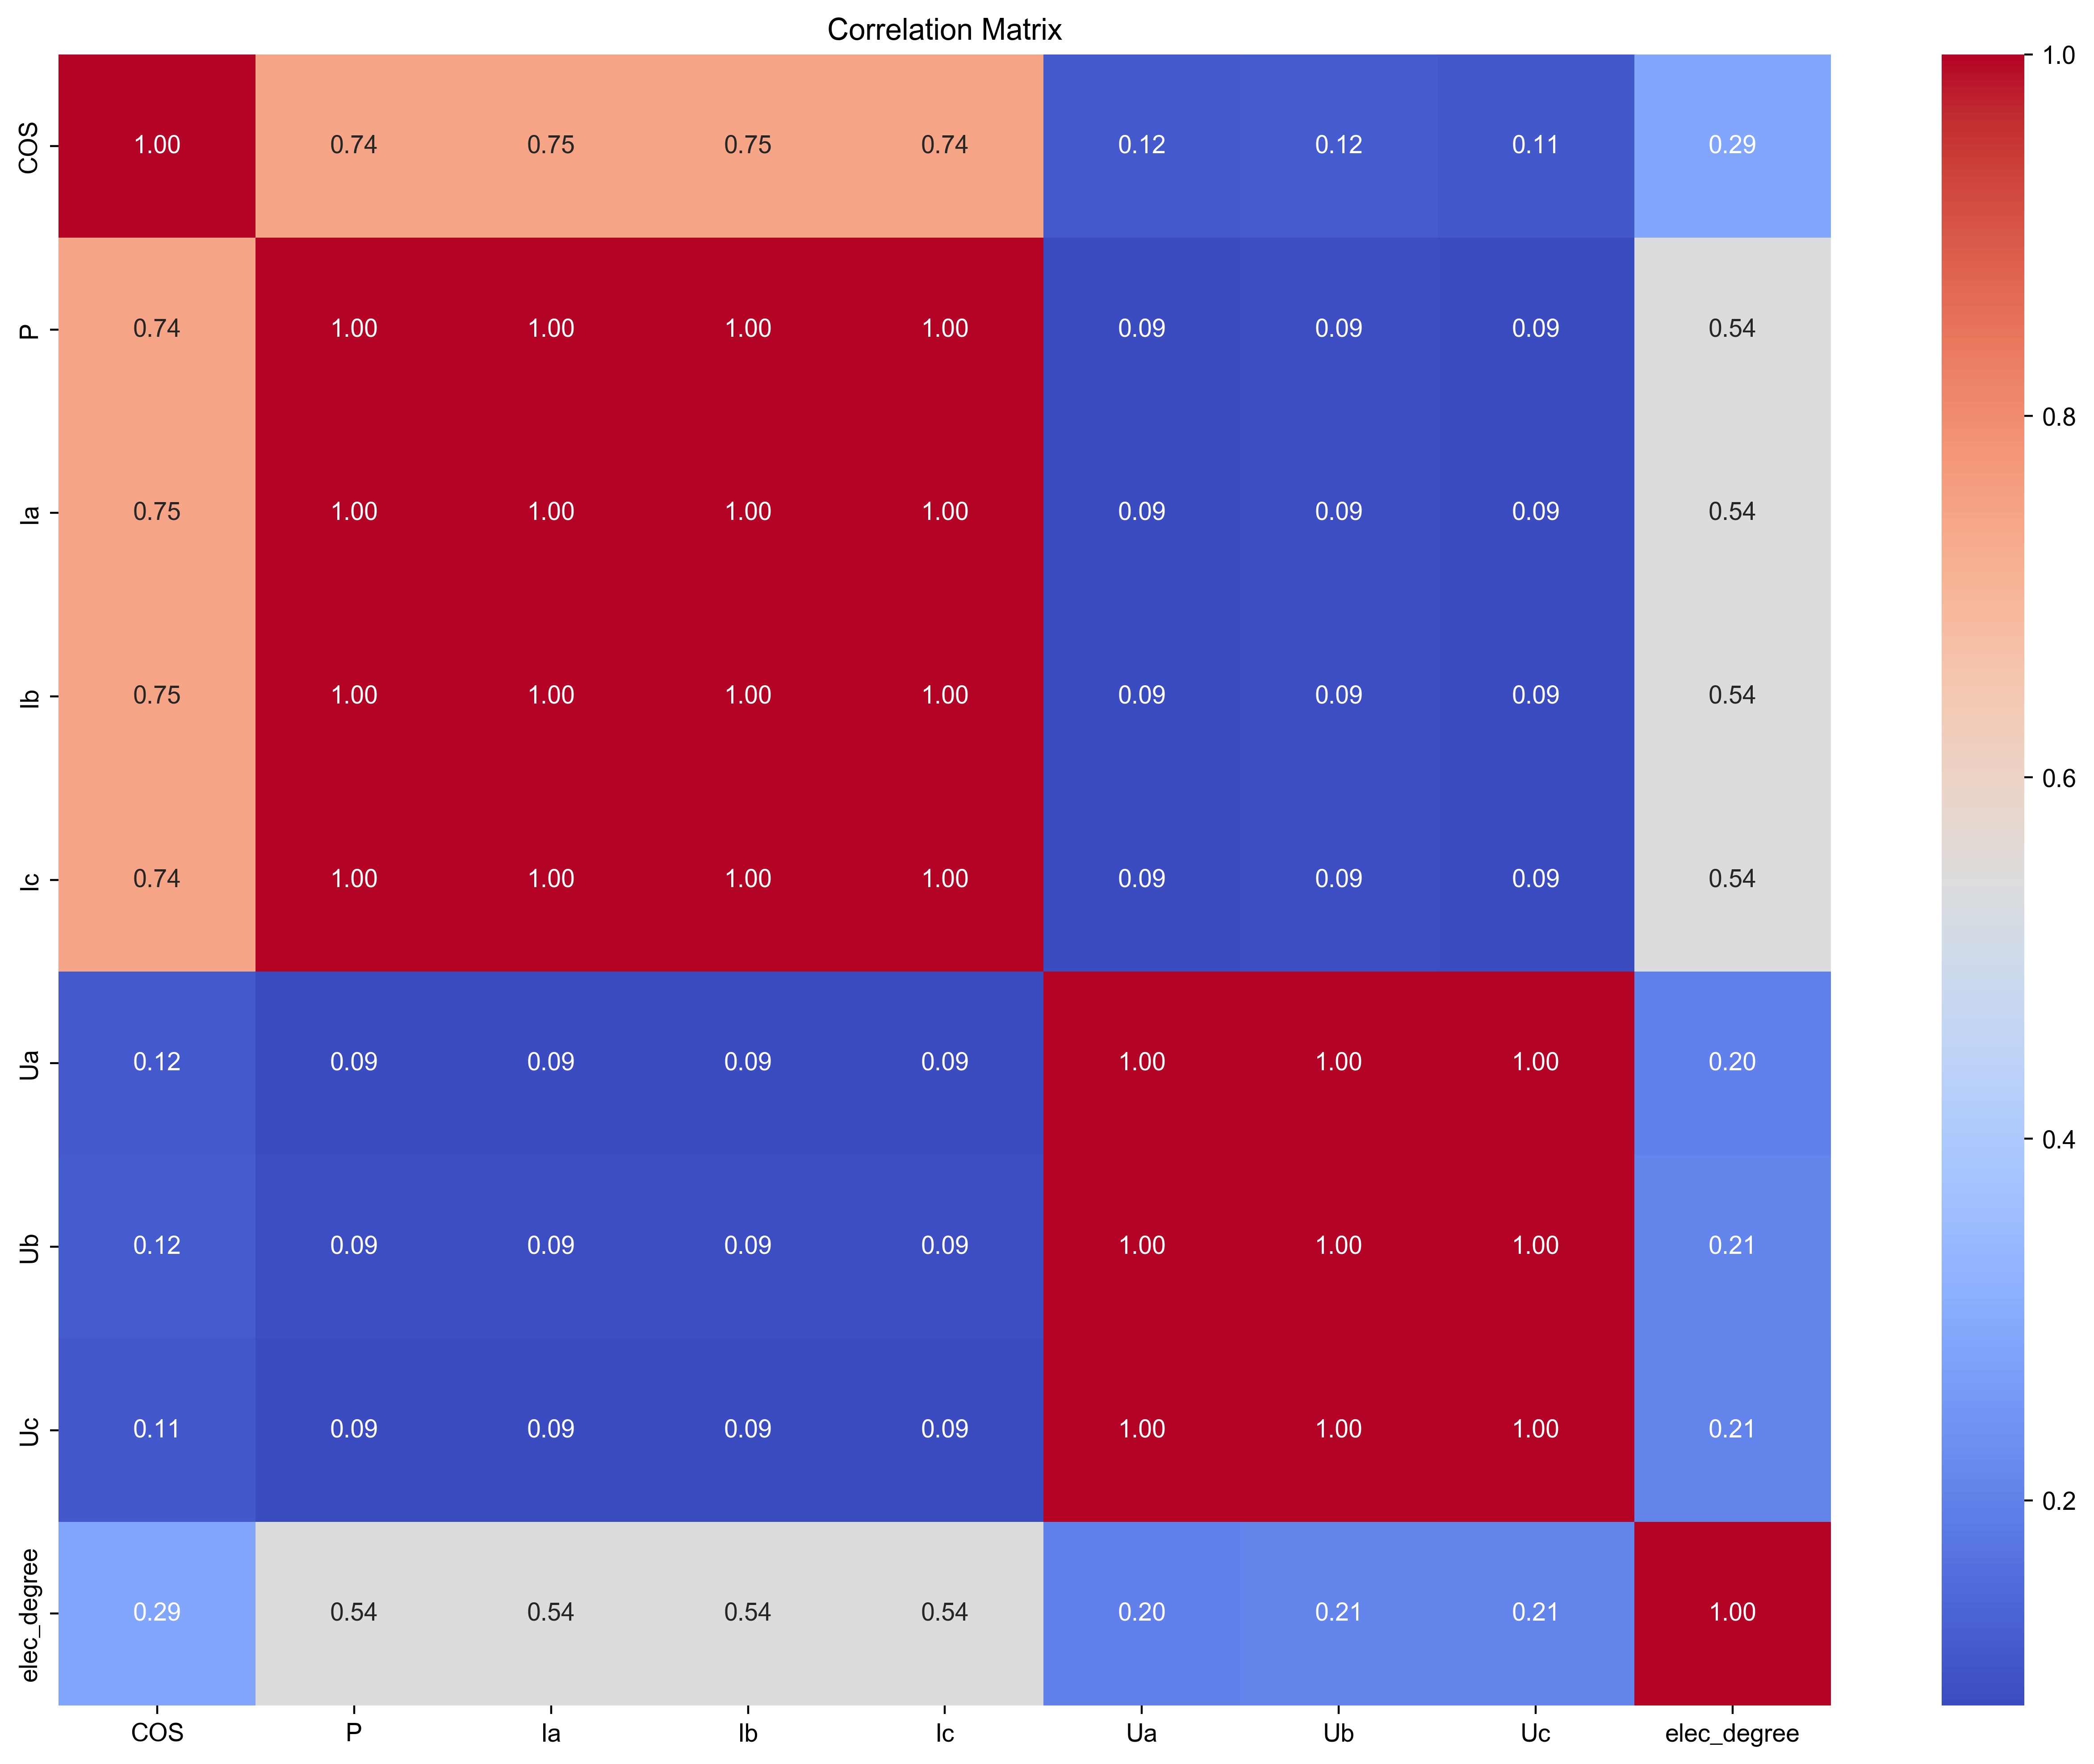

In [129]:
correlation_matrix = df.corr()
plt.figure(figsize=(16, 12), dpi=200)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 划分训练集和测试集


In [5]:
# 转化为 periodindex
y = y.to_period("15T")

In [6]:
y.index

PeriodIndex(['2022-01-01 00:00', '2022-01-01 00:15', '2022-01-01 00:30',
             '2022-01-01 00:45', '2022-01-01 01:00', '2022-01-01 01:15',
             '2022-01-01 01:30', '2022-01-01 01:45', '2022-01-01 02:00',
             '2022-01-01 02:15',
             ...
             '2022-01-08 21:30', '2022-01-08 21:45', '2022-01-08 22:00',
             '2022-01-08 22:15', '2022-01-08 22:30', '2022-01-08 22:45',
             '2022-01-08 23:00', '2022-01-08 23:15', '2022-01-08 23:30',
             '2022-01-08 23:45'],
            dtype='periodin]', name='collection_time', length=768)

In [7]:
y_train, y_test = temporal_train_test_split(y["Ia"], test_size=0.2)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ia'>)

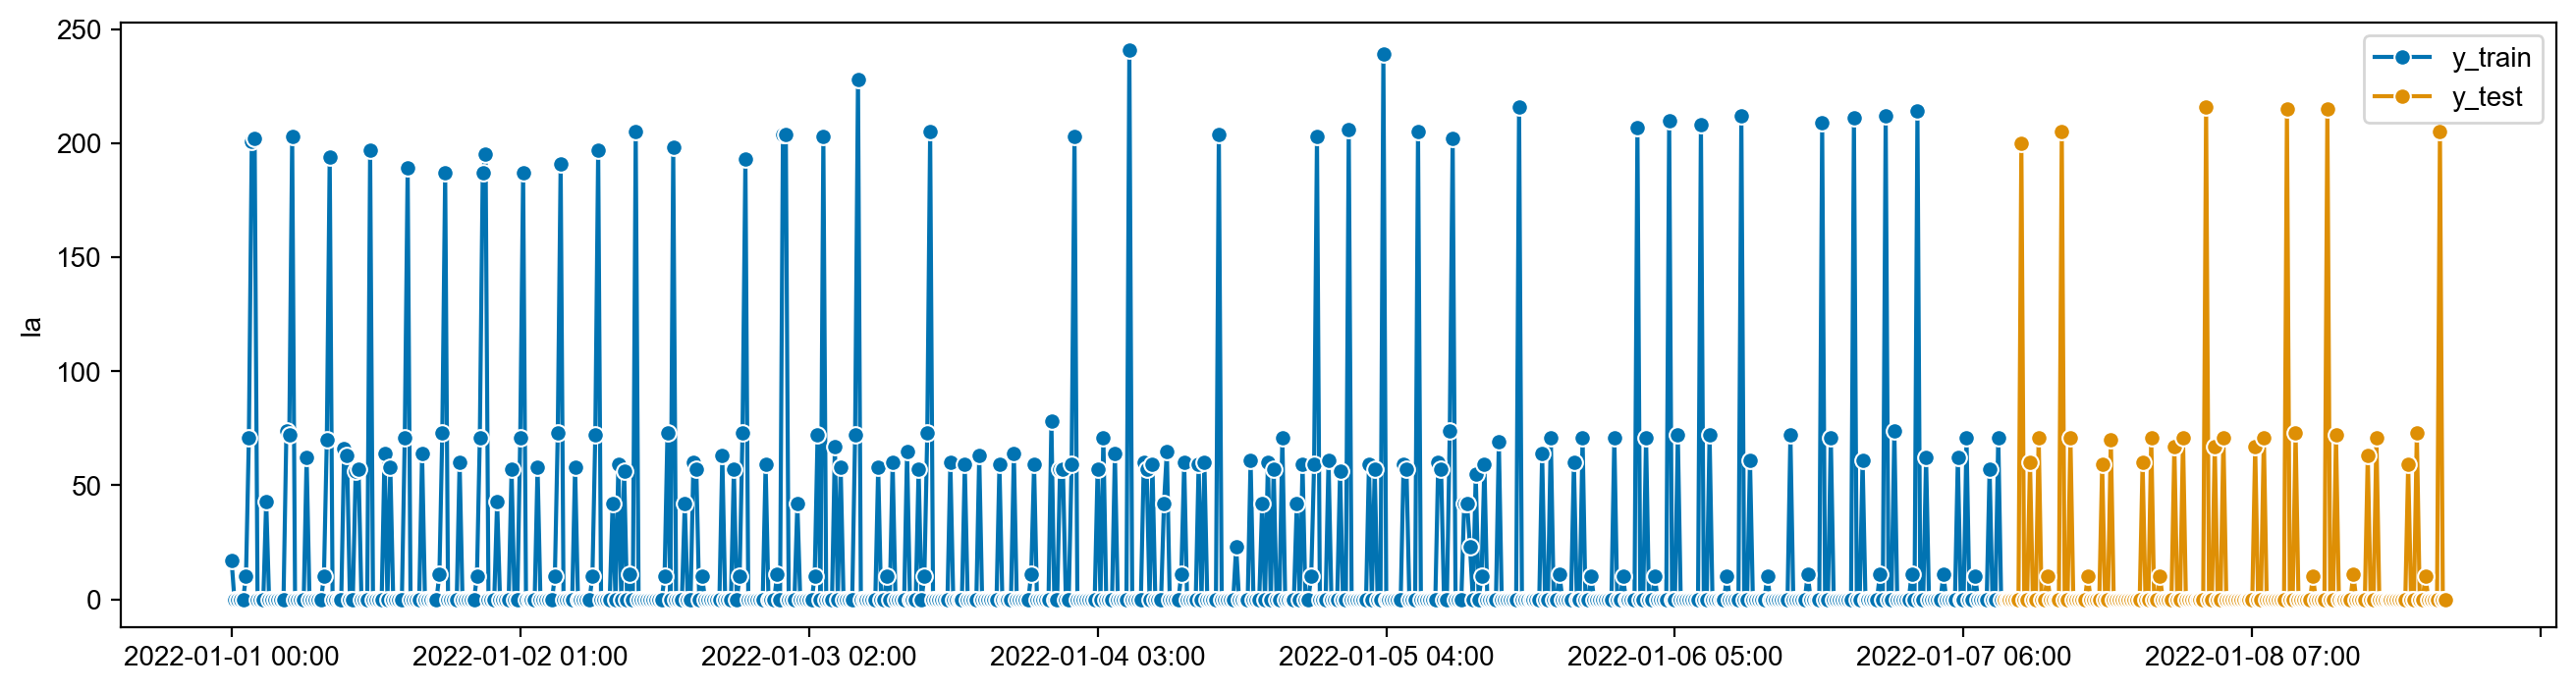

In [8]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])

## 随机森林模型


1.4106007584638675e+17


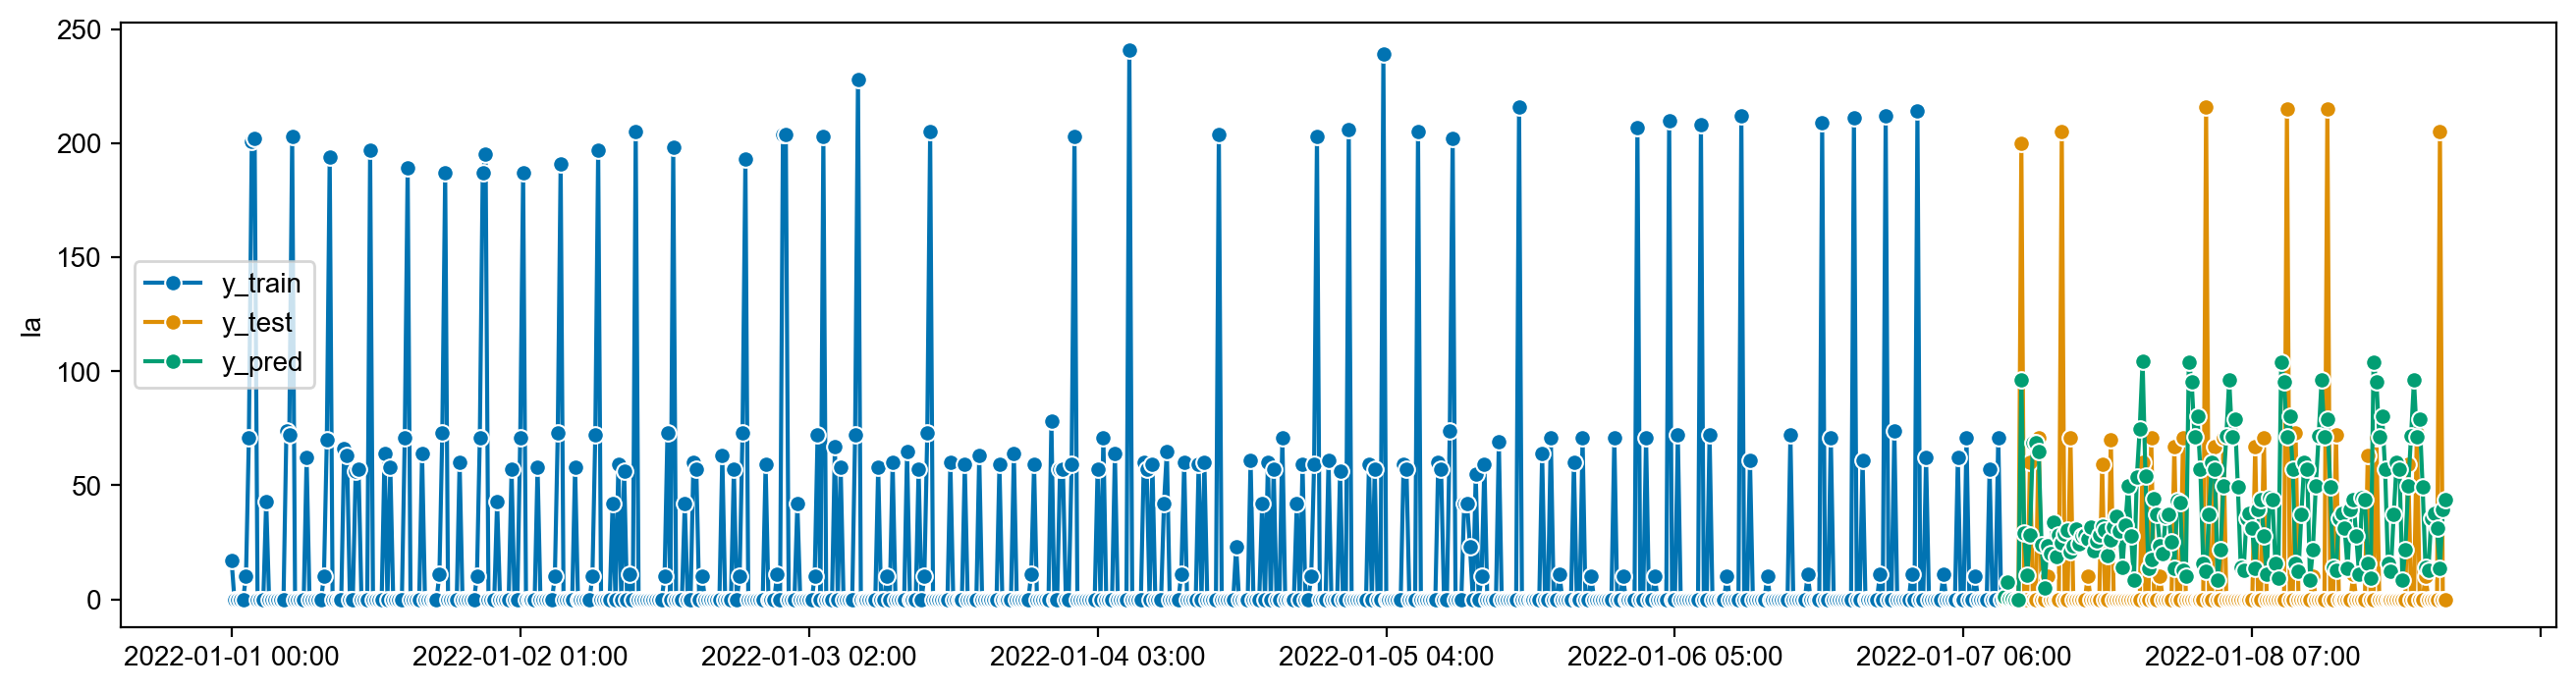

In [180]:
regressor = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=20)
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
pipe = TransformedTargetForecaster(
    steps=[
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", forecaster),
    ]
)
fh = ForecastingHorizon(y_test.index, is_relative=False)
pipe.fit(y_train)
y_pred = pipe.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

## XGBoost 模型


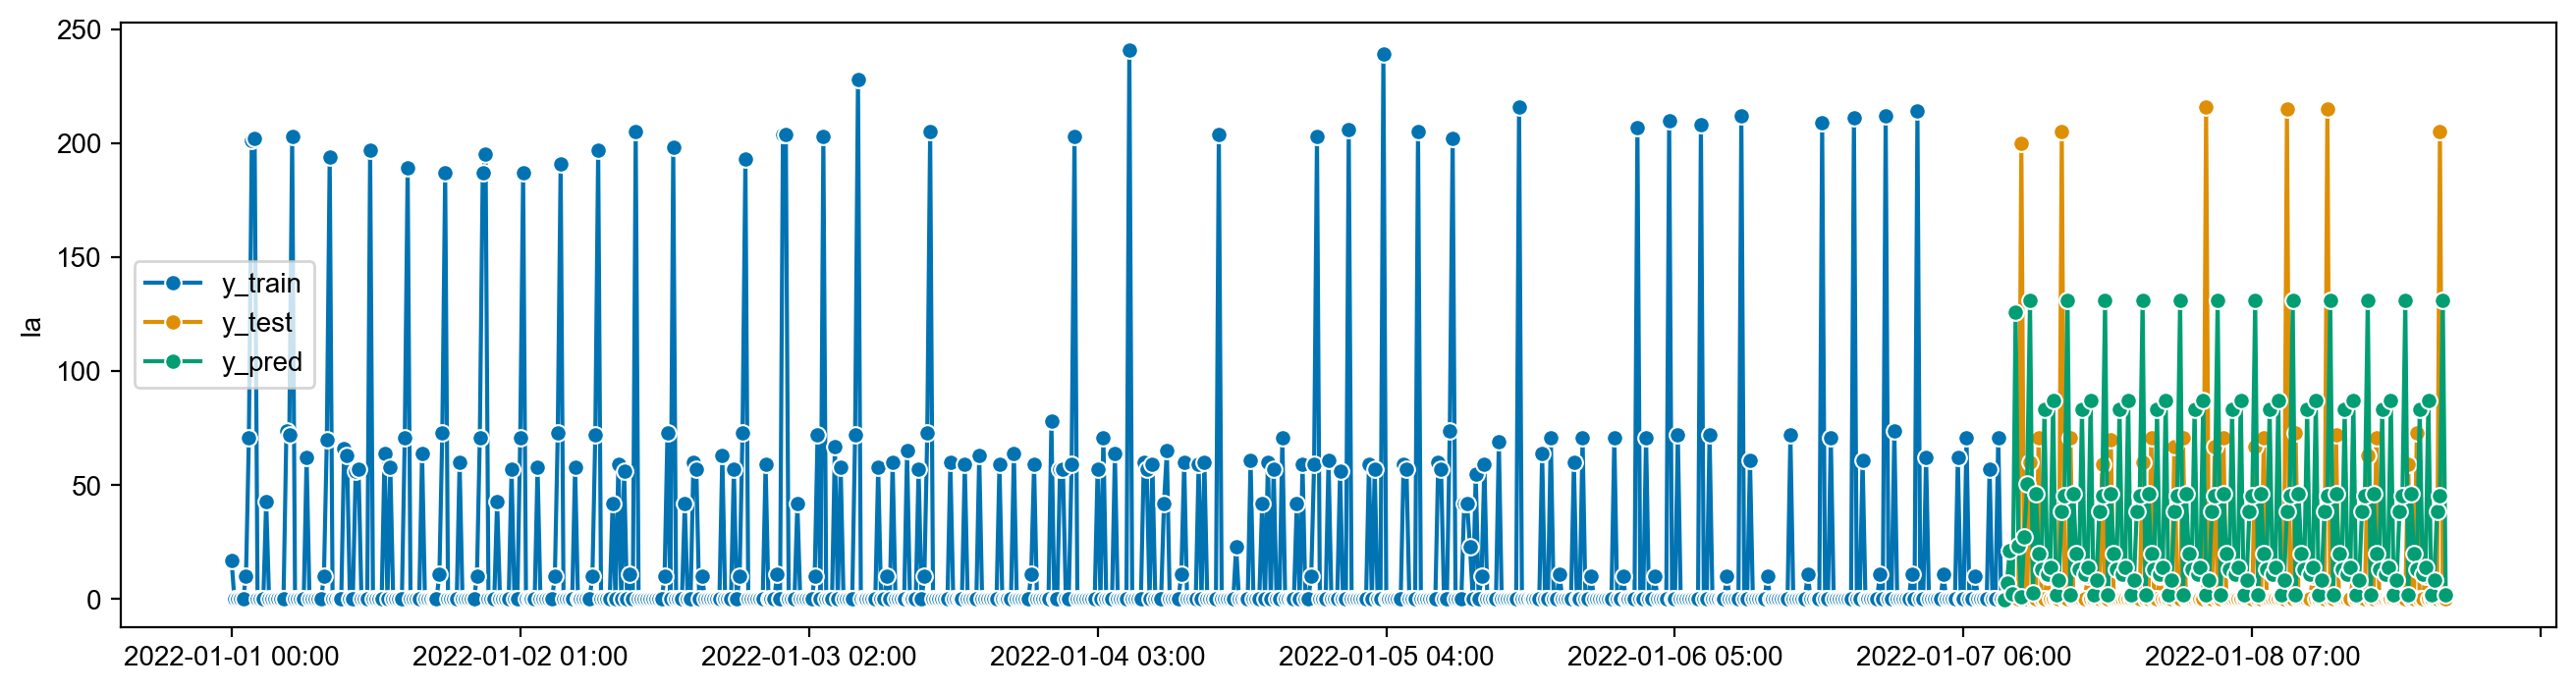

In [203]:
regressor = XGBRegressor(
    n_estimators=900,
    random_state=42,
    max_depth=20,
)
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
pipe = TransformedTargetForecaster(
    steps=[
        ("scaler", OptionalPassthrough(TabularToSeriesAdaptor(StandardScaler()))),
        ("forecaster", forecaster),
    ]
)
fh = ForecastingHorizon(y_test.index, is_relative=False)
pipe.fit(y_train)
y_pred = pipe.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

## 定义深度学习数据集


In [44]:
class UnivariateSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        n_lags: int,
        horizon: int,
        test_size: float = 0.2,
        batch_size: int = 16,
        feature_name: str = "",
    ) -> None:
        super().__init__()
        self.data = data
        self.n_lags = n_lags
        self.horizon = horizon
        self.test_size = test_size
        self.batch_size = batch_size
        self.feature_name = feature_name
        self.training: TimeSeriesDataSet
        self.validation: TimeSeriesDataSet
        self.test: TimeSeriesDataSet
        self.predict: TimeSeriesDataSet
        self.target_scaler = MinMaxScaler(feature_range=(0, 1))
        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data[self.feature_name]
        self.data["time_index"] = np.arange(len(self.data))
        self.data["group_id"] = 0

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None) -> None:
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()

        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]
        # predict_df = pd.concat([train_df, val_df, test_df])

        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        self.training = TimeSeriesDataSet(
            train_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=[self.feature_name],
            scalers={
                name: MinMaxScaler(feature_range=(0, 1)) for name in self.feature_name
            },
        )
        self.validation = TimeSeriesDataSet.from_dataset(
            self.training, val_df, stop_randomization=True
        )
        self.test = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )
        self.predict = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )

    def train_dataloader(self):
        return self.training.to_dataloader(
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return self.validation.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return self.test.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

    def predict_dataloader(self):
        return self.predict.to_dataloader(
            batch_size=self.batch_size,
            shuffle=False,
        )

## LSTM 模型

In [55]:
class LSTMModel(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 1,
        hidden_dim: int = 128,
        num_layers: int = 2,
        output_dim: int = 1,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("test_loss", loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("validation_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        y_pred = y_pred.detach().numpy()
        y_pred = self.trainer.datamodule.target_scaler.inverse_transform(y_pred)
        return y_pred

    def configure_optimizers(self):
        optimiser = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimiser

In [56]:
datamodule = UnivariateSeriesDataModule(
    df, n_lags=5, horizon=1, feature_name="Ia", batch_size=32
)

In [58]:
model = LSTMModel(input_dim=1, hidden_dim=128, num_layers=2, output_dim=1)
summary(model, input_size=(32, 5, 1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [32, 1]                   --
├─LSTM: 1-1                              [32, 5, 128]              199,168
├─Dropout: 1-2                           [32, 128]                 --
├─Linear: 1-3                            [32, 16]                  2,064
├─Linear: 1-4                            [32, 1]                   17
Total params: 201,249
Trainable params: 201,249
Non-trainable params: 0
Total mult-adds (M): 31.93
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.80
Estimated Total Size (MB): 0.97

In [59]:
from pytorch_lightning.loggers import TensorBoardLogger

pl.seed_everything(42)
logger = TensorBoardLogger("lightning_logs", name="voltage-prediction")

# early_stop_callback = EarlyStopping(
#     monitor="validation_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
# )

# model_checkpoint = ModelCheckpoint(
#     dirpath="checkpoints/univariate-checkpoints",
#     filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}",
# )
rich_progress_bar = RichProgressBar()
trainer = pl.Trainer(
    logger=logger,
    callbacks=[rich_progress_bar],
    max_epochs=500,
    accelerator="cpu",
)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
trainer.fit(model=model, datamodule=datamodule)

┏━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type    ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩
│ 0 │ lstm    │ LSTM    │  199 K │
│ 1 │ dropout │ Dropout │      0 │
│ 2 │ fc1     │ Linear  │  2.1 K │
│ 3 │ fc2     │ Linear  │     17 │
└───┴─────────┴─────────┴────────┘

Trainable params: 201 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 201 K                                                                                                
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=500` reached.


In [61]:
trainer.test(model=model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0260635856539011     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0260635856539011}]

In [62]:
trainer.validate(model=model, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.1004263162612915     │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.1004263162612915}]

In [63]:
prediction = trainer.predict(model=model, datamodule=datamodule)

Output()

In [64]:
prediction = np.concatenate(prediction)
prediction = prediction.flatten()

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Ia'>)

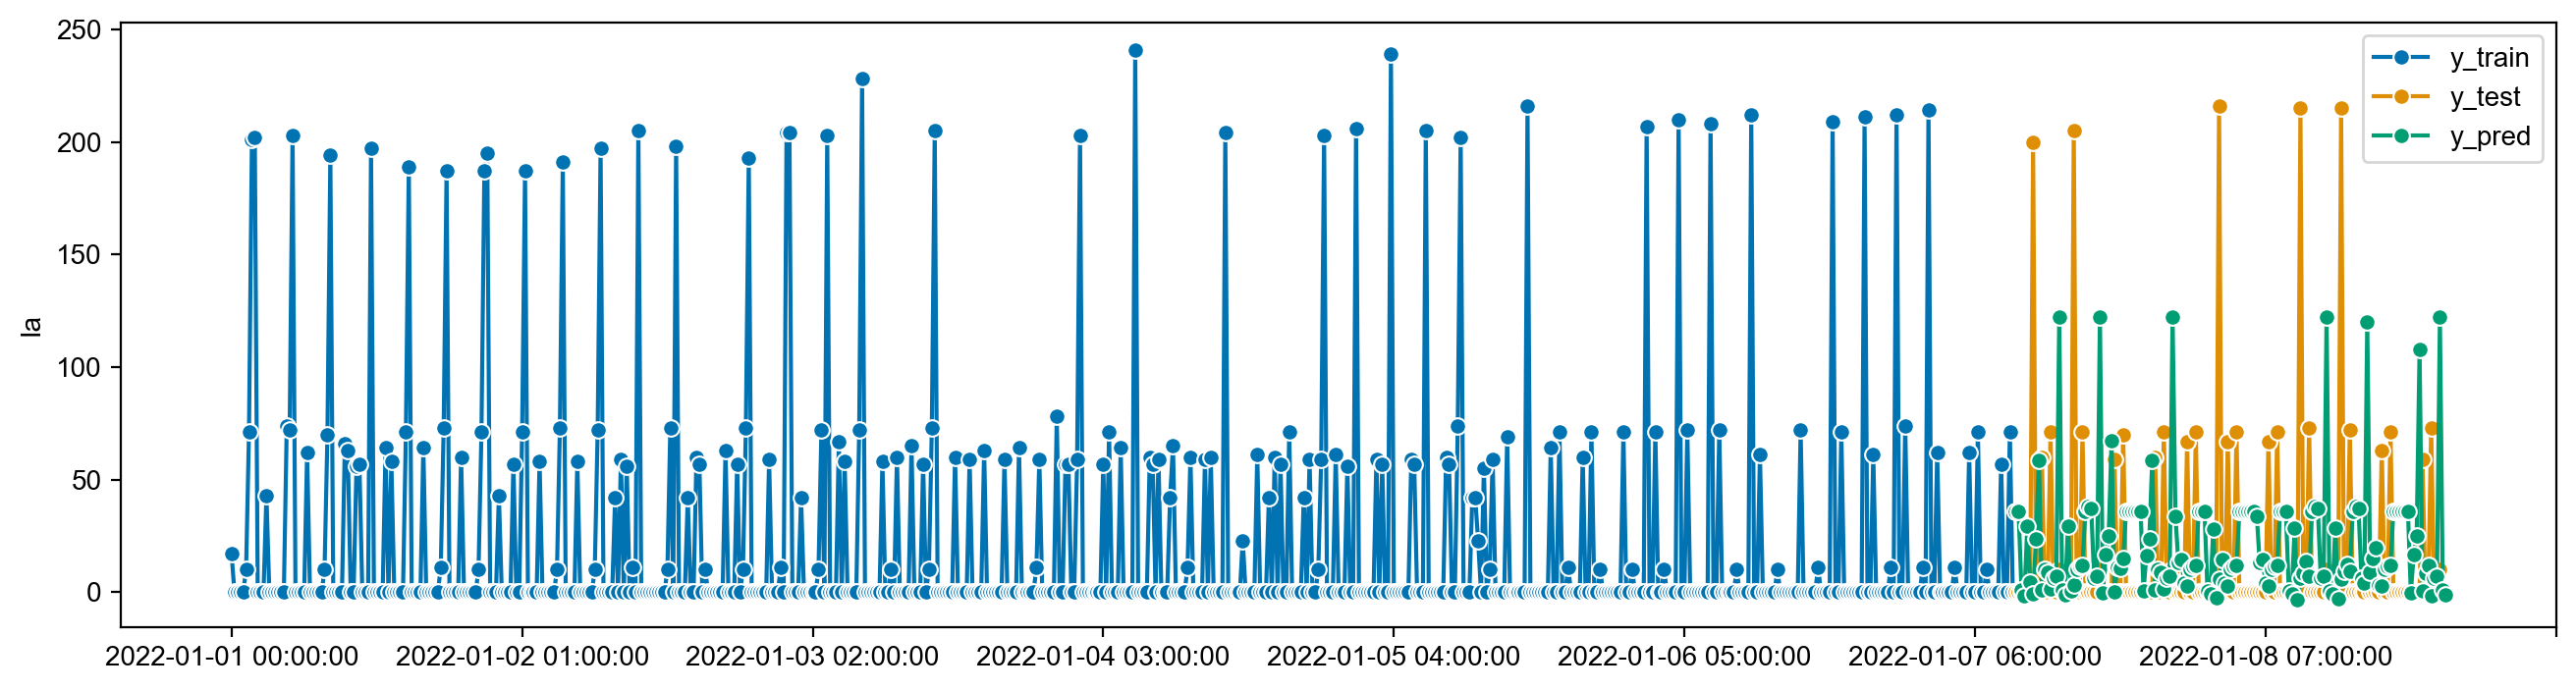

In [65]:
y_train, y_test = temporal_train_test_split(y["Ia"], test_size=0.2)
y_test = y_test.iloc[: len(prediction)]
y_pred = pd.Series(prediction, index=y_test.index)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [ ]:
model.eval()
torch.onnx.export(
    model,
    torch.randn(1, 5, 1),
    "../model/multi_output_lstm.onnx",
    export_params=True,
)